In [1]:
from os_helper import OsHelper
os_helper = OsHelper()

In [2]:
import pandas as pd
def use_base_data_instead_of_bloomberg(data: pd.DataFrame, name: str, max_year: int = 2019) -> pd.DataFrame:
    """
    This function formats the data from the base data folder to the same format as the Bloomberg data
    and filters out data beyond the year 2018, then converts the index back to a string format.

    Args:
        data (pd.DataFrame): Data to format correctly.
        name (str): Name of the column to be used as prefix for the ticker names.

    Returns:
        pd.DataFrame: DataFrame containing well formatted data up to the year 2018.
    """

    # Enlever le préfixe "{name}_" des noms des colonnes
    data.columns = data.columns.str.replace(f'{name}_', '')
    # Ajouter la chaîne " US Equity" à chaque nom de ticker restant
    data.columns = [f"{ticker} US Equity" for ticker in data.columns]
    # Changer le nom de la colonne 'date' en index et supprimer le nom de l'index
    data.index.rename(None, inplace=True)
    # Trier l'index dans l'ordre croissant
    data.sort_index(inplace=True)
    # Convertir l'index en DateTimeIndex pour faciliter le filtrage par année
    data.index = pd.to_datetime(data.index)
    # Conserver uniquement les données jusqu'à la fin max_year
    data = data[data.index.year <= max_year]
    # Convertir l'index de DateTimeIndex en chaîne de caractères au format 'YYYY-MM-DD'
    data.index = data.index.strftime('%Y-%m-%d')
    
    return data


In [3]:
close_data = os_helper.read_data(directory_name="base data", file_name="close.csv", index_col=0, low_memory=False)
volume_data = os_helper.read_data(directory_name="base data", file_name="volume.csv", index_col=0, low_memory=False)
adjusted_close_data = os_helper.read_data(directory_name="base data", file_name="adjusted_close.csv", index_col=0, low_memory=False)
print(close_data.head())
close = use_base_data_instead_of_bloomberg(data=close_data, name="close")
volume = use_base_data_instead_of_bloomberg(data=volume_data, name="volume")
adj_close = use_base_data_instead_of_bloomberg(data=adjusted_close_data, name="adjusted_close")

# save data
os_helper.write_data(directory_name="base data", file_name="new_close.csv", data_frame=close)
os_helper.write_data(directory_name="base data", file_name="new_volume.csv", data_frame=volume)
os_helper.write_data(directory_name="base data", file_name="new_tot_ret.csv", data_frame=adj_close)

Loaded file close.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/base data.
Loaded file volume.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/base data.
Loaded file adjusted_close.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/base data.
            close_CSCO  close_ISRG  close_TPR  close_DVN  close_MRO  close_BA  \
timestamp                                                                       
2023-10-06       53.45      295.68      28.19      43.70      24.59    187.38   
2023-10-05       53.07      290.09      27.58      42.85      24.24    186.29   
2023-10-04       53.45      290.28      27.84      43.35      24.40    186.73   
2023-10-03       53.65      288.04      27.95      45.75      25.68    188.92   
2023-10-02       54.39      294.98      28.58      45.65      25.59    187.83   

            close_GI

In [4]:
# from compute_metrics import ComputeMetrics
# 
# price_data = os_helper.read_data(directory_name="base data", file_name="new_close.csv", index_col=0, low_memory=False)
# trade_volume = os_helper.read_data(directory_name="base data", file_name="new_volume.csv", index_col=0, low_memory=False)
# spy = os_helper.read_data(directory_name="benchmark", file_name="SPY (1).csv", index_col=0, low_memory=False)
# 
# print(price_data.head())
# print(trade_volume.head())
# print(spy.head())
# 
# rolling_window_years = [1, 2, 3]
# 
# # Compute all risk metrics needed for the strategy and the filter
# metrics_calculator = ComputeMetrics(price_data=price_data, trade_volume=trade_volume, rolling_window_years=rolling_window_years,
#                                     benchmark_series=spy['Adj Close'])
# 
# final_df = metrics_calculator.compile_all_metrics()
# 
# os_helper.write_data(directory_name="transform data", file_name="all_metrics.csv", data_frame=final_df)

In [5]:
from get_rebal_dates import GetRebalDates, filter_by_rebalance_dates

all_metrics = os_helper.read_data(directory_name="transform data", file_name="all_metrics.csv", index_col=0, header=[0, 1])
print(all_metrics.head())

termination_date = '2015-01-01' # Last day of backtest
initial_year = 1999 # First year of the backtest
reb_month = 12
reb_week = 3
reb_weekday = 'FRI'
reb_frequency = 'S' # Q for quarterly, M for monthly, A for annual, S for semi-annual

# Get the rebalance dates of the strategy
get_reb_dates = GetRebalDates(termination_date=termination_date, initial_year=initial_year, reb_month=reb_month,
                              reb_week=reb_week, reb_weekday=reb_weekday, reb_frequency=reb_frequency)
rebalance_dates = get_reb_dates.reb_dates

print("Dates de rebalancement :")
for date in rebalance_dates:
    print(date)

reb_metrics = filter_by_rebalance_dates(get_reb_dates=get_reb_dates, data=all_metrics)
print(reb_metrics.head())

os_helper.write_data(directory_name="transform data", file_name=f"rebalance_metrics.csv", data_frame=reb_metrics)

Loaded file all_metrics.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/transform data.
                   A US Equity                                          \
           average_turnover_1Y average_turnover_2Y average_turnover_3Y   
1999-11-01                                                               
1999-11-02                 NaN                 NaN                 NaN   
1999-11-03                 NaN                 NaN                 NaN   
1999-11-04                 NaN                 NaN                 NaN   
1999-11-05                 NaN                 NaN                 NaN   
1999-11-08                 NaN                 NaN                 NaN   

                                                                              \
           beta_1Y beta_2Y beta_3Y volatility_1Y volatility_2Y volatility_3Y   
1999-11-01                                                                     
1999-11-02     NaN    

In [6]:
from filter import Filter

data = os_helper.read_data(directory_name="transform data", file_name="rebalance_metrics.csv", index_col=0)
print(data)
risk_filter = Filter(data=data)

risk_top_n = 140
liquidity_top_n = 200

filtered_data = risk_filter.apply_filters(liquidity_top_n=liquidity_top_n, risk_top_n=risk_top_n)
print(filtered_data.head())

os_helper.write_data(directory_name="transform data", file_name="filtered_data.csv", data_frame=filtered_data)

Loaded file rebalance_metrics.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/transform data.
            Date          Ticker  average_turnover_1Y  average_turnover_2Y  \
0     2000-12-15     A US Equity         2.000540e+08                  NaN   
1     2000-12-15  AAPL US Equity         3.560394e+08                  NaN   
2     2000-12-15   ABT US Equity         3.427124e+08                  NaN   
3     2000-12-15  ADBE US Equity         2.422944e+08                  NaN   
4     2000-12-15   ADI US Equity         2.387479e+08                  NaN   
...          ...             ...                  ...                  ...   
8349  2014-12-19  XRAY US Equity         4.044158e+07         3.644939e+07   
8350  2014-12-19   XYL US Equity         3.680362e+07         3.621255e+07   
8351  2014-12-19   YUM US Equity         2.307088e+08         2.429554e+08   
8352  2014-12-19   ZBH US Equity         1.242653e+08         1.04552

In [7]:
from weighting import InverseMetricsWeighting

filtered_data = os_helper.read_data(directory_name="transform data", file_name="filtered_data.csv", index_col=0)
print(filtered_data)

years_to_inverse = [1, 2, 3]
metric_to_inverse = "beta"
weighting_list = [] # Equal weighting of betas
min_weight = 0.00001
max_weight = 0.05

inverse_metrics_weighting = InverseMetricsWeighting(filtered_data=filtered_data, years_list=years_to_inverse,
                                                    target_metric=metric_to_inverse, weight_list=weighting_list,
                                                    min_limit=min_weight, max_limit=max_weight)
inverse_metrics_weighting_df = inverse_metrics_weighting.compute_inverse_weighted_metrics()
print(inverse_metrics_weighting_df)

os_helper.write_data(directory_name="transform data", file_name="inverse_metrics_weighting.csv", data_frame=inverse_metrics_weighting_df)

Loaded file filtered_data.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/transform data.
            Date          Ticker  average_turnover_1Y  average_turnover_2Y  average_turnover_3Y   beta_1Y   beta_2Y   beta_3Y  volatility_1Y  volatility_2Y  volatility_3Y
0     2002-12-13   ADM US Equity         1.928895e+07         2.096770e+07         1.995469e+07  0.354951  0.380743  0.367312       0.265237       0.308633       0.330793
1     2002-12-13   ADP US Equity         1.290485e+08         1.229771e+08         1.184466e+08  0.988513  0.885232  0.765565       0.421196       0.375484       0.377369
2     2002-12-13   AEE US Equity         2.740266e+07         2.205358e+07         1.965659e+07  0.486260  0.314623  0.289219       0.247957       0.233742       0.238914
3     2002-12-13   AEP US Equity         7.461715e+07         5.969405e+07         4.843943e+07  1.021821  0.639904  0.500216       0.573373       0.443004       0.40487

In [8]:
from portfolio_returns import PortfolioReturns

prices = os_helper.read_data(directory_name="base data", file_name="new_tot_ret.csv", index_col=0, sep=',')
print(prices.head())
weighting_df = os_helper.read_data(directory_name="transform data", file_name="inverse_metrics_weighting.csv", index_col=0)
print(weighting_df.head())

rebalance_lag = 7 # delay between weight computation and implementation
transaction_fee = 0.001 # 0.1% transaction fee

pf_returns = PortfolioReturns(prices=prices, weighting_data=weighting_df, rebalance_lag=rebalance_lag, transaction_fee=transaction_fee)
drifted_weights = pf_returns.drifted_weights
print(drifted_weights.head())
portfolio_returns = pf_returns.portfolio_returns
print(portfolio_returns.head())

os_helper.write_data(directory_name="final data", file_name="portfolio_returns.csv", data_frame=portfolio_returns)
os_helper.write_data(directory_name="final data", file_name="drifted_weights.csv", data_frame=drifted_weights)

Loaded file new_tot_ret.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/base data.
            CSCO US Equity  ISRG US Equity  TPR US Equity  DVN US Equity  MRO US Equity  BA US Equity  GILD US Equity  MDT US Equity  V US Equity  A US Equity  MO US Equity  CTRA US Equity  MCHP US Equity  EIX US Equity  BBY US Equity  GEN US Equity  WBA US Equity  DTE US Equity  C US Equity  T US Equity  ...  WYNN US Equity  RHI US Equity  EFX US Equity  NUE US Equity  CTSH US Equity  SWK US Equity  MU US Equity  TRV US Equity  L US Equity  AEP US Equity  CI US Equity  BALL US Equity  JNJ US Equity  DOV US Equity  CRM US Equity  PGR US Equity  WAT US Equity  BWA US Equity  BLK US Equity  PPL US Equity
1999-11-01       25.121693             NaN            NaN      12.686863       5.197426     28.661792        1.482176      23.654637          NaN          NaN      1.371226        1.034941        5.547514      14.141193      14.044962       2.290155 

/Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Codes/Strat/portfolio_returns.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.replace(0, np.nan, inplace=True)
/Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Codes/Strat/portfolio_returns.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[ticker].loc[first_valid_idx:last_valid_idx] = \


Unable to calculate transaction costs for 2004-12-24 00:00:00 (Holiday).
Unable to calculate transaction costs for 2009-12-25 00:00:00 (Holiday).
Unable to calculate transaction costs for 2010-12-24 00:00:00 (Holiday).
           A US Equity ACN US Equity ADBE US Equity ADI US Equity ADM US Equity ADP US Equity ADSK US Equity AEE US Equity AEP US Equity AES US Equity AFL US Equity AIZ US Equity AKAM US Equity ALL US Equity AMAT US Equity AMT US Equity AON US Equity APA US Equity APD US Equity APH US Equity  ... TT US Equity TXT US Equity UNP US Equity UPS US Equity VFC US Equity VLO US Equity VMC US Equity VRSN US Equity VTR US Equity WAT US Equity WBA US Equity WDC US Equity WEC US Equity WELL US Equity WMB US Equity XEL US Equity XRAY US Equity YUM US Equity ZBH US Equity ZION US Equity
2002-12-20         0.0           0.0            0.0           0.0      0.007307      0.006088            0.0      0.007432      0.006365           0.0      0.006239           0.0            0.0      0

Loaded file sectors_drifted_weights.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/final data.
Loaded file sectors_compounded_returns.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/final data.
            Communication Services  Consumer Discretionary  Consumer Staples    Energy  Financials  Health Care  Industrials  Information Technology  Materials  Real Estate  Utilities
2002-12-20                     0.0                0.076836          0.142102  0.073129    0.120419     0.085260     0.140403                0.006129   0.125174     0.094470   0.136078
2002-12-23                     0.0                0.075524          0.141855  0.073422    0.120195     0.085654     0.140480                0.006111   0.126526     0.094943   0.135290
2002-12-24                     0.0                0.075425          0.142061  0.073269    0.120172     0.086069     0.140425               

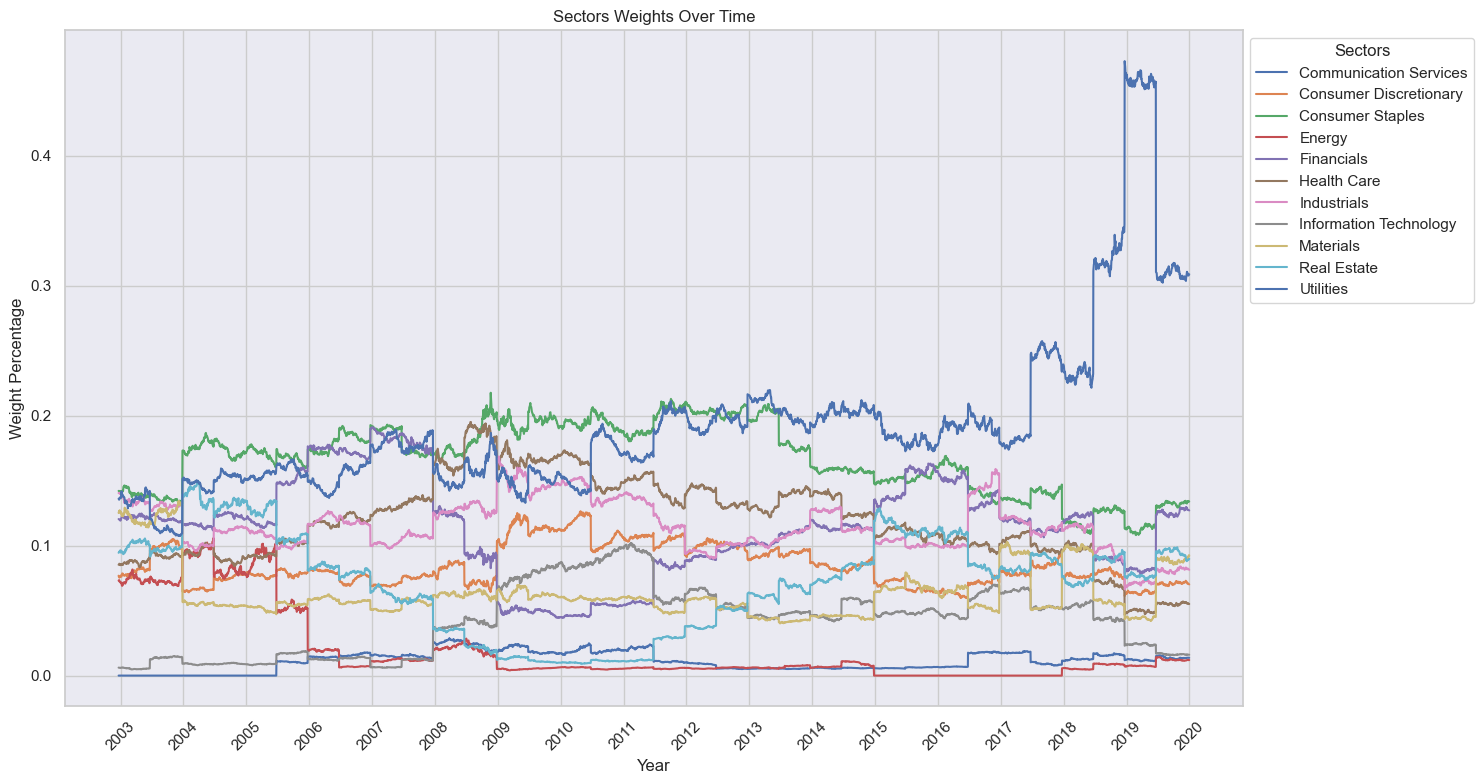

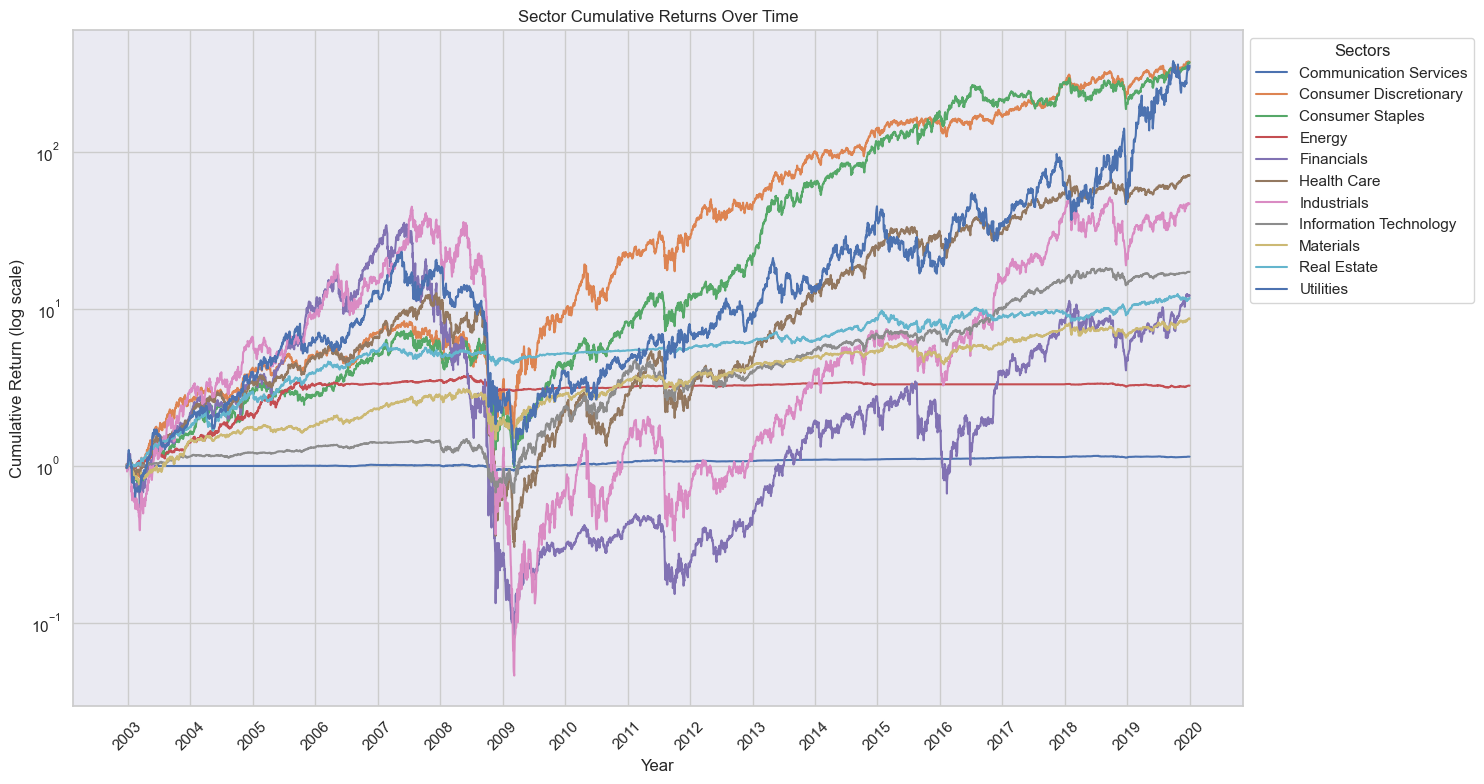

In [9]:
from visualization import plot_sector_cumulative_returns, plot_sector_weights_over_time, save_figure

sectors_drifted_weights = os_helper.read_data(directory_name='final data', file_name='sectors_drifted_weights.csv', index_col=0)
sectors_compounded_returns = os_helper.read_data(directory_name='final data', file_name='sectors_compounded_returns.csv', index_col=0)

print(sectors_drifted_weights.head())
print(sectors_compounded_returns.head())

fig = plot_sector_weights_over_time(df=sectors_drifted_weights, title="Sectors Weights Over Time")
save_figure(fig=fig, folder_path='../Graphs', file_name='sector_weights_over_time.png')

# Plotting the sector cumulative returns
fig_returns = plot_sector_cumulative_returns(df=sectors_compounded_returns, title="Sector Cumulative Returns Over Time")
save_figure(fig=fig_returns, folder_path='../Graphs', file_name='sector_cumulative_returns_over_time.png')

In [10]:
from fama_regress import FamaFrenchRegression

ff_factors = os_helper.read_data(directory_name='benchmark', file_name='F-F_Research_Data_5_Factors_2x3_daily.csv')
portfolio_returns = os_helper.read_data(directory_name='final data', file_name='portfolio_returns.csv')

print(ff_factors.head())
print(portfolio_returns.head())

# Instantiate the FamaFrenchRegression class
ff_regression = FamaFrenchRegression(ff_factors, portfolio_returns)

# Run the regression
ff_regression.run_regression()

# Retrieve and display the regression results
regression_results = ff_regression.get_regression_results()
print(regression_results)

 # Run the rolling regression
rolling_results = ff_regression.run_rolling_regression(window_size=252)

# Print or use the rolling regression results
print(rolling_results)


Loaded file F-F_Research_Data_5_Factors_2x3_daily.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/benchmark.
Loaded file portfolio_returns.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/final data.
   Unnamed: 0  Mkt-RF   SMB   HML   RMW   CMA     RF
0    19630701   -0.67  0.02 -0.35  0.03  0.13  0.012
1    19630702    0.79 -0.28  0.28 -0.08 -0.21  0.012
2    19630703    0.63 -0.18 -0.10  0.13 -0.25  0.012
3    19630705    0.40  0.09 -0.28  0.07 -0.30  0.012
4    19630708   -0.63  0.07 -0.20 -0.27  0.06  0.012
   Unnamed: 0  Portfolio_Returns
0  2002-12-20           0.000000
1  2002-12-23           0.002887
2  2002-12-24          -0.003936
3  2002-12-26           0.004266
4  2002-12-27          -0.011185
                                 OLS Regression Results                                
Dep. Variable:          Excess_Return   R-squared (uncentered):                   0

In [11]:
from perf_report import PerfReport

benchmark_prices = os_helper.read_data(directory_name="benchmark", file_name="SPY (1).csv", index_col=0)
benchmark_prices.sort_index(inplace=True)
benchmark_prices.index.name = None
benchmark_prices = benchmark_prices[["Adj Close"]]
benchmark_prices.columns = ["SPY"]
# convert benchmark prices index to datetime
benchmark_prices.index = pd.to_datetime(benchmark_prices.index)
# keep only data from 2000-01-01 to 2014-12-31
benchmark_prices = benchmark_prices[benchmark_prices.index.year >= 2000]
# keep data before 2014-12-31 adn drop 
benchmark_prices = benchmark_prices[benchmark_prices.index.year <= 2014]
# convert benchmark prices index to string
benchmark_prices.index = benchmark_prices.index.strftime('%Y-%m-%d')

print(benchmark_prices.head())

strategy_returns = os_helper.read_data(directory_name="final data", file_name="portfolio_returns.csv", index_col=0)
strategy_returns.sort_index(inplace=True)
strategy_returns.index.name = None
# convert benchmark prices index to datetime
strategy_returns.index = pd.to_datetime(strategy_returns.index)
# keep only data from 2000-01-01 to 2014-12-31
strategy_returns = strategy_returns[strategy_returns.index.year >= 2000]
# keep data before 2014-12-31
strategy_returns = strategy_returns[strategy_returns.index.year <= 2014]
# convert benchmark prices index to string
strategy_returns.index = strategy_returns.index.strftime('%Y-%m-%d')

print(strategy_returns.head())
strategy_returns.columns = ["Portfolio_Returns"]

perf_report = PerfReport(port_returns=strategy_returns, bench_returns=benchmark_prices, strat_name="InverseMetrics")
print(perf_report.get_performance_indicators(rf=0.01, periods_per_year=252))
perf_report.generate_html_report(rf=0.01, periods_per_year=252)

Loaded file SPY (1).csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/benchmark.
                  SPY
2000-01-03  94.262543
2000-01-04  90.576317
2000-01-05  90.738373
2000-01-06  89.280067
2000-01-07  94.465073
Loaded file portfolio_returns.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/final data.
            Portfolio_Returns
2002-12-20           0.000000
2002-12-23           0.002887
2002-12-24          -0.003936
2002-12-26           0.004266
2002-12-27          -0.011185
{'Cumulative Returns': 4.8146640832411585, 'CAGR': 0.1574637386137332, 'Sharpe': 0.9198111540309014, 'Sortino': 1.3165315008096146, 'Calmar': 0.36907310574680563, 'Max Drawdown': -0.4266464723705923, 'Average Return': 0.000634425290816742, 'Volatility': 0.16293762735135797, 'Tail Ratio': 0.9892777123740502, 'Gain to Pain Ratio': 0.2037264220171055, 'Value at Risk (VaR)': -0.01624873578679168, 'Conditio

/Users/thomasvaudescal/.virtualenvs/PolyHacks/lib/python3.11/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


Moved file InverseMetrics_backtesting_report.html to folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Codes/reports.


In [12]:
from stickyRebalance import prepare_drifted_weights_format_submission

drifted_weights = os_helper.read_data(directory_name='final data', file_name='drifted_weights.csv', index_col=0)
print(drifted_weights.head())

submission_weights = prepare_drifted_weights_format_submission(drifted_weights=drifted_weights)

print(submission_weights.head())
print(submission_weights.tail())

os_helper.write_data(directory_name='final data', file_name='submission_weights.csv', data_frame=submission_weights)

Loaded file drifted_weights.csv from folder /Users/thomasvaudescal/Documents/Mes_documents/30_TradingClub/PolyFinance/PolyHacks/Data/final data.
            A US Equity  ACN US Equity  ADBE US Equity  ADI US Equity  ADM US Equity  ADP US Equity  ADSK US Equity  AEE US Equity  AEP US Equity  AES US Equity  AFL US Equity  AIZ US Equity  AKAM US Equity  ALL US Equity  AMAT US Equity  AMT US Equity  AON US Equity  APA US Equity  APD US Equity  APH US Equity  ...  TT US Equity  TXT US Equity  UNP US Equity  UPS US Equity  VFC US Equity  VLO US Equity  VMC US Equity  VRSN US Equity  VTR US Equity  WAT US Equity  WBA US Equity  WDC US Equity  WEC US Equity  WELL US Equity  WMB US Equity  XEL US Equity  XRAY US Equity  YUM US Equity  ZBH US Equity  ZION US Equity
2002-12-20          0.0            0.0             0.0            0.0       0.007307       0.006088             0.0       0.007432       0.006365            0.0       0.006239            0.0             0.0       0.006611             

In [13]:
submission_weights.describe()

,weight_A,weight_ACN,weight_ADBE,weight_ADI,weight_ADM,weight_ADP,weight_ADSK,weight_AEE,weight_AEP,weight_AES,weight_AFL,weight_AIZ,weight_AKAM,weight_ALL,weight_AMAT,weight_AMT,weight_AON,weight_APA,weight_APD,weight_APH,...,weight_TT,weight_TXT,weight_UNP,weight_UPS,weight_VFC,weight_VLO,weight_VMC,weight_VRSN,weight_VTR,weight_WAT,weight_WBA,weight_WDC,weight_WEC,weight_WELL,weight_WMB,weight_XEL,weight_XRAY,weight_YUM,weight_ZBH,weight_ZION
count,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,...,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000
mean,0.001626,0.004126,0.001846,0.003317,0.006328,0.006843,0.001276,0.008192,0.007723,0.001990,0.003488,0.002412,0.000192,0.004854,0.000587,0.004443,0.006479,0.002091,0.005341,0.002162,...,0.000350,0.000433,0.002759,0.000277,0.006566,0.001979,0.002435,0.003133,0.006320,0.005704,0.003689,0.000453,0.009526,0.002073,0.000405,0.008216,0.006806,0.005737,0.005591,0.002714
std,0.002573,0.003544,0.002414,0.002874,0.002241,0.001139,0.002233,0.001304,0.001669,0.002612,0.003282,0.002929,0.000922,0.002925,0.001562,0.002960,0.002208,0.003666,0.000653,0.002610,...,0.001189,0.001444,0.003050,0.001343,0.000821,0.004094,0.002542,0.002948,0.004230,0.002739,0.003475,0.001512,0.001252,0.003317,0.001361,0.002333,0.001369,0.002668,0.003026,0.003005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.004064,0.000000,0.004673,0.004839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003069,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.004834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006686,0.000000,0.000000,0.000000,0.004180,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.005256,0.006300,0.000000,0.007259,0.006559,0.000000,0.000000,0.000000,0.000000,0.003860,0.000000,0.000000,0.005265,0.000000,0.004907,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006002,0.000000,0.000000,0.000000,0.004642,0.004732,0.000000,0.000000,0.008544,0.000000,0.000000,0.007138,0.005842,0.005716,0.005600,0.000000
50%,0.000000,0.006276,0.000000,0.004840,0.005977,0.006937,0.000000,0.008342,0.007554,0.000000,0.004954,0.000000,0.000000,0.005922,0.000000,0.005528,0.006313,0.000000,0.005378,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006602,0.000000,0.000000,0.004455,0.006344,0.006009,0.005468,0.000000,0.009705,0.000000,0.000000,0.008597,0.006745,0.006750,0.006444,0.000000
75%,0.004628,0.007227,0.004708,0.005742,0.007255,0.007587,0.002825,0.009215,0.009127,0.004918,0.006420,0.005385,0.000000,0.006998,0.000000,0.006960,0.007716,0.006416,0.005792,0.004928,...,0.000000,0.000000,0.006105,0.000000,0.007191,0.000000,0.004953,0.006028,0.008918,0.007341,0.006763,0.000000,0.010399,0.005711,0.000000,0.009843,0.007539,0.007279,0.007638,0.005794
max,0.007014,0.009053,0.006304,0.008594,0.013761,0.010358,0.006363,0.010510,0.010883,0.006978,0.008846,0.009388,0.005445,0.008507,0.005291,0.008179,0.011089,0.010740,0.007082,0.007692,...,0.006002,0.006036,0.007459,0.007099,0.008450,0.017257,0.007102,0.007334,0.016552,0.012772,0.009457,0.006644,0.013943,0.016575,0.006459,0.011792,0.010909,0.008952,0.010173,0.007797
